In [1]:
import pandas as pd
import os
import requests
import zipfile
import shutil
from glob import glob
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# 下载数据集
links = pd.read_csv('./mchar_data_list_0515.csv')    #修改成你电脑对应的路径
dataset_path = "./dataset"
print(f"数据集目录：{dataset_path}")
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)
for i,link in enumerate(links['link']):
    file_name = links['file'][i]
    print(file_name, '\t', link)
    file_name = os.path.join(dataset_path,file_name)
    if not os.path.exists(file_name):
        response = requests.get(link, stream=True)
        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
zip_list = ['mchar_train', 'mchar_test_a', 'mchar_val']
for little_zip in zip_list:
    zip_name = os.path.join(dataset_path,little_zip)
    if not os.path.exists(zip_name):
        file_name = dataset_path + '/' + little_zip + '.zip'
        print(file_name)
        zip_file = zipfile.ZipFile(file_name, 'r')
        zip_file.extractall(path = dataset_path)
# if os.path.exists(os.path.join(dataset_path,'__MACOSX')):
#     shutil.rmtree(os.path.join(dataset_path,'__MACOSX'))


数据集目录：./dataset
mchar_train.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.zip
mchar_train.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
mchar_val.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.zip
mchar_val.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
mchar_test_a.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_test_a.zip
mchar_sample_submit_A.csv 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_sample_submit_A.csv


In [2]:
# 构建数据集路径索引
data_dir = {
    'train_data': f'{dataset_path}/mchar_train/',
    'val_data': f'{dataset_path}/mchar_val/',
    'test_data': f'{dataset_path}/mchar_test_a/',
    'train_label': f'{dataset_path}/mchar_train.json',
    'val_label': f'{dataset_path}/mchar_val.json',
    'submit_file': f'{dataset_path}/mchar_sample_submit_A.csv'
}

train_list = glob(data_dir['train_data']+'*.png')
test_list = glob(data_dir['test_data']+'*.png')
val_list = glob(data_dir['val_data']+'*.png')
print('train image counts: %d'%len(train_list))
print('val image counts: %d'%len(val_list))
print('test image counts: %d'%len(test_list))

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [3]:
# 看train数据集第一张的信息，长宽高等
def look_train_json():
    with open(data_dir['train_label'], 'r', encoding='utf-8') as f:
        content = f.read()

    content = json.loads(content)
    print(content['000000.png'])

look_train_json()

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [4]:
# 看需要输出文件的信息
def look_submit():
    df = pd.read_csv(data_dir['submit_file'], sep=',')
    print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


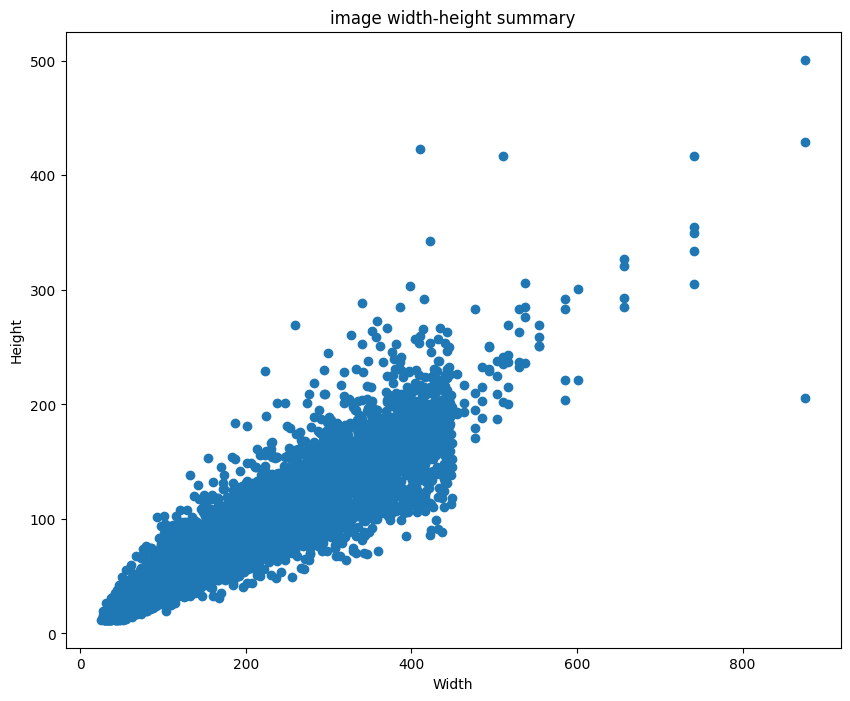

In [5]:

# 统计图片的大小
def img_size_summary():
    sizes = []

    for img in glob(data_dir['train_data']+'*.png'):
        img = Image.open(img)

        sizes.append(img.size)

    sizes = np.array(sizes)

    plt.figure(figsize=(10, 8))
    plt.scatter(sizes[:, 0], sizes[:, 1])
    plt.xlabel('Width')
    plt.ylabel('Height')

    plt.title('image width-height summary')
    # 保存图像到文件
    plt.show()

img_size_summary()

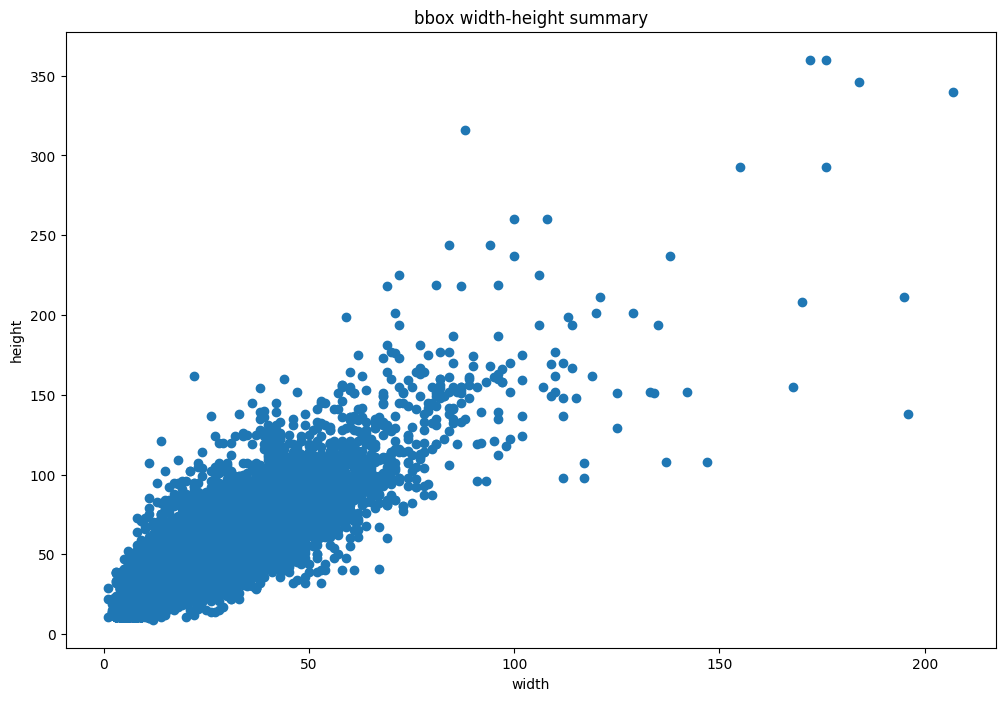

In [6]:

#统计bbox的大小
def bbox_summary():
    marks = json.loads(open(data_dir['train_label'], 'r').read())
    bboxes = []

    for img, mark in marks.items():
        for i in range(len(mark['label'])):
            bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

    bboxes = np.array(bboxes)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(bboxes[:, 2], bboxes[:, 3])
    ax.set_title('bbox width-height summary')
    ax.set_xlabel('width')
    ax.set_ylabel('height')
    # 保存图像到文件
    plt.show()

bbox_summary()


In [7]:

#统计图片分别含有数字的个数
def label_summary():
    marks = json.load(open(data_dir['train_label'], 'r'))
    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1

    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d' % (k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


In [8]:

import os
from glob import glob
import torch as t
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import torch.nn.functional as F
import json
from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.resnet import resnet50, resnet34,resnet18,resnet101
from torchsummary import summary
import random
from torchvision.models.mobilenet import MobileNetV2
from torch.optim import Adam
#超参数设定
class Config:
    batch_size = 64
    lr = 1e-3
    momentum = 0.9
    weights_decay = 1e-4
    class_num = 11
    eval_interval = 1
    checkpoint_interval = 5
    print_interval = 50
    checkpoints = '/data/duyongkun/CPX/OCR_competition/crnn/checkpoints'   # 自己创建一个文件夹用来储存权重
    pretrained = None 
    start_epoch = 0
    epoches = 30
    smooth = 0.1
    erase_prob = 0.5

config = Config()

In [9]:

class DigitsDataset(Dataset):
    """
    DigitsDataset
    Params:
      data_dir(string): data directory
      label_path(string): label path
      aug(bool): wheather do image augmentation, default: True
    """
    def __init__(self, mode='train', size=(128, 256), aug=True):
        super(DigitsDataset, self).__init__()
        self.aug = aug
        self.size = size
        self.mode = mode
        self.width = 224
        self.batch_count = 0
        if mode == 'test':
            self.imgs = glob(data_dir['test_data'] + '*.png')
            self.labels = None
        else:
            labels = json.load(open(data_dir['%s_label' % mode], 'r'))
            imgs = glob(data_dir['%s_data' % mode] + '*.png')
            self.imgs = [(img, labels[os.path.split(img)[-1]]) for img in imgs \
                         if os.path.split(img)[-1] in labels]

    def __getitem__(self, idx):
        if self.mode != 'test':
            img, label = self.imgs[idx]
        else:
            img = self.imgs[idx]
            label = None
        img = Image.open(img)
        trans0 = [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        min_size = self.size[0] if (img.size[1] / self.size[0]) < ((img.size[0] / self.size[1])) else self.size[1]
        trans1 = [
            transforms.Resize(128),
            transforms.CenterCrop((128, self.width))
        ]
        if self.aug:
            trans1.extend([
                transforms.ColorJitter(0.1, 0.1, 0.1),
                transforms.RandomGrayscale(0.1),
                transforms.RandomAffine(15, translate=(0.05, 0.1), shear=5)
            ])
        trans1.extend(trans0)
        if self.mode != 'test':
            return transforms.Compose(trans1)(img), t.tensor(
                label['label'][:4] + (4 - len(label['label'])) * [10]).long()
        else:
            # trans1.append(transforms.RandomErasing(scale=(0.02, 0.1)))
            return transforms.Compose(trans1)(img), self.imgs[idx]

    def __len__(self):
        return len(self.imgs)

    def collect_fn(self, batch):
        imgs, labels = zip(*batch)
        if self.mode == 'train':
            if self.batch_count > 0 and self.batch_count % 10 == 0:
                self.width = random.choice(range(224, 256, 16))

        self.batch_count += 1
        return t.stack(imgs).float(), t.stack(labels) 

In [10]:
class DigitsResnet50(nn.Module):
    def __init__(self, class_num=11):
        super(DigitsResnet50, self).__init__()
        self.net = resnet50(pretrained=True)
        self.net = nn.Sequential(*list(self.net.children())[:-1]) 
        self.cnn = self.net
        self.fc1 = nn.Linear(2048, class_num)
        self.fc2 = nn.Linear(2048, class_num)
        self.fc3 = nn.Linear(2048, class_num)
        self.fc4 = nn.Linear(2048, class_num)

    def forward(self, img):
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        return c1, c2, c3, c4

In [11]:
class LabelSmoothEntropy(nn.Module):
    def __init__(self, smooth=0.1, class_weights=None, size_average='mean'):
        super(LabelSmoothEntropy, self).__init__()
        self.size_average = size_average
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, preds, targets):
        lb_pos, lb_neg = 1 - self.smooth, self.smooth / (preds.shape[0] - 1)
        smoothed_lb = t.zeros_like(preds).fill_(lb_neg).scatter_(1, targets[:, None], lb_pos)
        log_soft = F.log_softmax(preds, dim=1)
        if self.class_weights is not None:
            loss = -log_soft * smoothed_lb * self.class_weights[None, :]
        else:
            loss = -log_soft * smoothed_lb
        loss = loss.sum(1)
        if self.size_average == 'mean':
            return loss.mean()
        elif self.size_average == 'sum':
            return loss.sum()
        else:
            raise NotImplementedError

In [12]:
class Trainer:
    def __init__(self, val=True):
        self.device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
        print('Using device: %s' % self.device)
        self.train_set = DigitsDataset(mode='train')
        self.train_loader = DataLoader(self.train_set, batch_size=config.batch_size, shuffle=True, num_workers=8,
                                       pin_memory=True, \
                                       drop_last=True, collate_fn=self.train_set.collect_fn)
        if val:
            self.val_loader = DataLoader(DigitsDataset(mode='val', aug=False), batch_size=config.batch_size, \
                                         num_workers=8, pin_memory=True, drop_last=False)
        else:
            self.val_loader = None

        self.model = DigitsResnet50(config.class_num).to(self.device)
        self.criterion = LabelSmoothEntropy().to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,
                              amsgrad=False)
        self.lr_scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2, eta_min=0)
        self.best_acc = 0
        self.best_checkpoint_path = ""
        # 是否载入预训练模型
        if config.pretrained is not None:
            self.load_model(config.pretrained)
            # print('Load model from %s'%config.pretrained)
            if self.val_loader is not None:
                acc = self.eval()
            self.best_acc = acc
            print('Load model from %s, Eval Acc: %.2f' % (config.pretrained, acc * 100))

    def train(self):
        for epoch in range(config.start_epoch, config.epoches):
            print('Epoch %d/%d' % (epoch + 1, config.epoches))
            acc = self.train_epoch(epoch)
            if (epoch + 1) % config.eval_interval == 0:
                print('Start Evaluation')
                if self.val_loader is not None:
                    acc = self.eval()
                #保存最优模型
                if acc > self.best_acc:
                    os.makedirs(config.checkpoints, exist_ok=True)
                    save_path = os.path.join(config.checkpoints,'epoch-resnet50-%d-acc-%.2f.pth' % (epoch + 1, acc * 100))
                    self.save_model(save_path)
                    print('%s saved successfully...' % save_path)
                    self.best_acc = acc
                    self.best_checkpoint_path = save_path

    def train_epoch(self, epoch):
        total_loss = 0
        corrects = 0
        tbar = tqdm(self.train_loader)
        self.model.train()
        for i, (img, label) in enumerate(tbar):
            img = img.to(self.device)
            label = label.to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(img)
            loss = self.criterion(pred[0], label[:, 0]) + \
                   self.criterion(pred[1], label[:, 1]) + \
                   self.criterion(pred[2], label[:, 2]) + \
                   self.criterion(pred[3], label[:, 3])
            total_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            temp = t.stack([ \
                pred[0].argmax(1) == label[:, 0], \
                pred[1].argmax(1) == label[:, 1], \
                pred[2].argmax(1) == label[:, 2], \
                pred[3].argmax(1) == label[:, 3], ], dim=1)
            corrects += t.all(temp, dim=1).sum().item()
            tbar.set_description(
                'loss: %.3f, acc: %.3f' % (loss / (i + 1), corrects * 100 / ((i + 1) * config.batch_size)))
            if (i + 1) % config.print_interval == 0:
                self.lr_scheduler.step()
        return corrects * 100 / ((i + 1) * config.batch_size)

    def eval(self):
        self.model.eval()
        corrects = 0
        with t.no_grad():
            tbar = tqdm(self.val_loader)
            for i, (img, label) in enumerate(tbar):
                img = img.to(self.device)
                label = label.to(self.device)
                pred = self.model(img)
                temp = t.stack([
                    pred[0].argmax(1) == label[:, 0], \
                    pred[1].argmax(1) == label[:, 1], \
                    pred[2].argmax(1) == label[:, 2], \
                    pred[3].argmax(1) == label[:, 3], \
                    ], dim=1)
                corrects += t.all(temp, dim=1).sum().item()
                tbar.set_description('Val Acc: %.2f' % (corrects * 100 / ((i + 1) * config.batch_size)))
        self.model.train()
        return corrects / (len(self.val_loader) * config.batch_size)

    def save_model(self, save_path, save_opt=False, save_config=False):
        dicts = {}
        dicts['model'] = self.model.state_dict()
        if save_opt:
            dicts['opt'] = self.optimizer.state_dict()
        if save_config:
            dicts['config'] = {s: config.__getattribute__(s) for s in dir(config) if not s.startswith('_')}
        t.save(dicts, save_path)

    def load_model(self, load_path, changed=False, save_opt=False, save_config=False):
        dicts = t.load(load_path)
        if not changed:
            self.model.load_state_dict(dicts['model'])
        # else:
        #     dicts = t.load(load_path)['model']
        #     keys = list(net.state_dict().keys())
        #     values = list(dicts.values())
        #     new_dicts = {k: v for k, v in zip(keys, values)}
        #     self.model.load_state_dict(new_dicts)

        if save_opt:
            self.optimizer.load_state_dict(dicts['opt'])

        if save_config:
            for k, v in dicts['config'].items():
                config.__setattr__(k, v)

In [ ]:
print('__name__:', __name__)
if __name__ == '__main__':
    trainer = Trainer()
    trainer.train()

__name__: __main__
Using device: cuda


d:\Projects\AI\Street\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\AI\Street\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30


In [ ]:
def parse2class(prediction):
    """
    Params:
    prediction(tuple of tensor): 
    """
    ch1, ch2, ch3, ch4 = prediction
    char_list = [str(i) for i in range(10)]
    char_list.append('')
    ch1, ch2, ch3, ch4 = ch1.argmax(1), ch2.argmax(1), ch3.argmax(1), ch4.argmax(1)
    ch1, ch2, ch3, ch4 = [char_list[i.item()] for i in ch1], [char_list[i.item()] for i in ch2], \
                    [char_list[i.item()] for i in ch3], [char_list[i.item()] for i in ch4] 
    res = [c1+c2+c3+c4 for c1, c2, c3, c4 in zip(ch1, ch2, ch3, ch4)]             
    return res

def write2csv(results,csv_path):
    """
    results(list):
    """
    # 定义输出文件
    df = pd.DataFrame(results, columns=['file_name', 'file_code'])
    df['file_name'] = df['file_name'].apply(lambda x: x.split('/')[-1])
    save_name = csv_path
    df.to_csv(save_name, sep=',', index=None)
    print('Results.saved to %s'%save_name)

def predicts(model_path,csv_path):
    test_loader = DataLoader(DigitsDataset(mode='test', aug=False), batch_size=config.batch_size, shuffle=False,\
                    num_workers=8, pin_memory=True, drop_last=False)
    results = []
    res_path = model_path
    res_net = DigitsResnet50().cuda()
    res_net.load_state_dict(t.load(res_path)['model'])
    print('Load model from %s successfully'%model_path)
    tbar = tqdm(test_loader)
    res_net.eval()
    with t.no_grad():
        for i, (img, img_names) in enumerate(tbar):
            img = img.cuda()
            pred = res_net(img)
            results += [[name, code] for name, code in zip(img_names, parse2class(pred))]
    results = sorted(results, key=lambda x: x[0])
    write2csv(results,csv_path)
    return results

In [ ]:
predicts(trainer.best_checkpoint_path,"result.csv")